In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
file_path = "/content/drive/MyDrive/coffee.zip"

In [13]:
import zipfile
import os

extraction_path = '/content/extracted_data'
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)
print(f"File extracted to: {extraction_path}")

File extracted to: /content/extracted_data


In [14]:
os.listdir('/content/extracted_data')

['Coffee Bean.csv', 'test', 'train']

In [15]:
!ls -al /content/extracted_data

total 84
drwxr-xr-x 4 root root  4096 Nov 27 11:22  .
drwxr-xr-x 1 root root  4096 Nov 27 11:22  ..
-rw-r--r-- 1 root root 67175 Nov 27 11:26 'Coffee Bean.csv'
drwxr-xr-x 6 root root  4096 Nov 27 11:22  test
drwxr-xr-x 6 root root  4096 Nov 27 11:22  train


In [42]:
!ls /content/extracted_data/train/

Dark  Green  Light  Medium


In [17]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [18]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dir = "/content/extracted_data/train"
test_dir = "/content/extracted_data/test"

train_set = ImageFolder(train_dir, transform=transform)
test_set = ImageFolder(test_dir, transform=transform)

print("Liczba obrazów w zbiorze:", len(train_set))
print("Liczba obrazów w zbiorze:", len(test_set))

Liczba obrazów w zbiorze: 1200
Liczba obrazów w zbiorze: 400


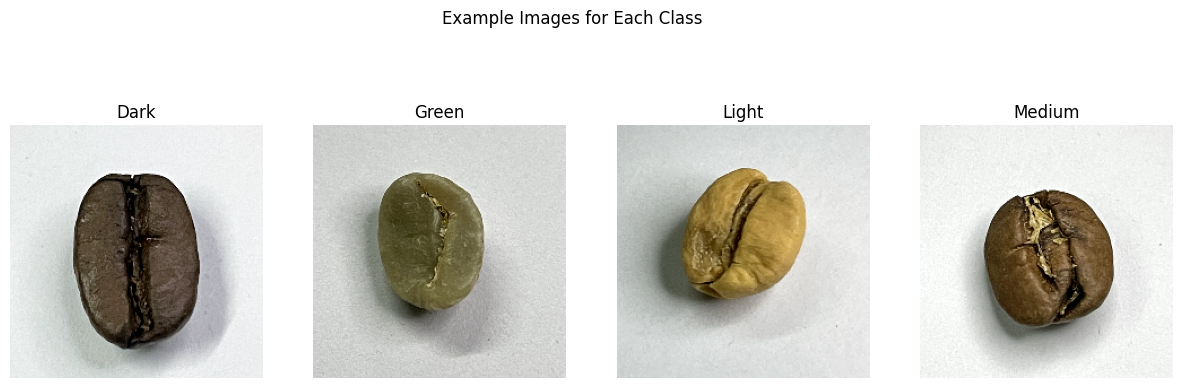

In [19]:
import matplotlib.pyplot as plt
import numpy as np


classes = train_set.classes
class_to_idx = train_set.class_to_idx

class_images = {}

for i in range(len(train_mc_set)):
    img, label_idx = train_mc_set[i]
    class_name = classes[label_idx]
    if class_name not in class_images:
        class_images[class_name] = img
    if len(class_images) == len(classes):
        break

fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, class_name in enumerate(classes):
    img_tensor = class_images[class_name]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    axes[i].imshow(img_np)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.suptitle('Example Images for Each Class')
plt.show()

In [41]:
print("Załadowane klasy:", train_set.classes)
print("Mapowanie klas -> indeksy:", train_set.class_to_idx)
print()

Załadowane klasy: ['Dark', 'Green', 'Light', 'Medium']
Mapowanie klas -> indeksy: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}



In [21]:
from torch.utils.data import Dataset

In [22]:
idx_dark = train_set.class_to_idx["Dark"]

class DarkVsRestDataset(Dataset):
  def __init__(self, base_dataset, idx_dark):
    self.base_dataset = base_dataset
    self.idx_dark = idx_dark

  def __len__(self):
    return len(self.base_dataset)
  def __getitem__(self,idx):
    img, label = self.base_dataset[idx]
    label_bin = 1 if label == self.idx_dark else 0
    return img, label_bin

In [23]:
train_bin = DarkVsRestDataset(train_set, idx_dark)
test_bin = DarkVsRestDataset(test_set, idx_dark)

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_bin, batch_size=32, shuffle=True)
test_loader = DataLoader(test_bin, batch_size=32,shuffle=False)

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3,padding=1)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(64*28*28,128)
    self.fc2 = nn.Linear(128,1)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [26]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie: ", device)

model = MyCNN().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

num_epochs = 5

Używane urządzenie:  cuda


In [27]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.4170
Epoch 2/5, Loss: 0.1486
Epoch 3/5, Loss: 0.0837
Epoch 4/5, Loss: 0.0598
Epoch 5/5, Loss: 0.0403


In [28]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Accuracy na zbiorze testowym: {test_acc:.4f}")

Accuracy na zbiorze testowym: 0.9925


In [43]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights


imagenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_set_raw = ImageFolder(train_dir, transform=imagenet_transform)
test_set_raw  = ImageFolder(test_dir,  transform=imagenet_transform)

train_bin = DarkVsRestDataset(train_set_raw, idx_dark)
test_bin = DarkVsRestDataset(test_set_raw, idx_dark)


train_loader = DataLoader(train_bin, batch_size=32, shuffle=True)
test_loader = DataLoader(test_bin, batch_size=32,shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

weights = ResNet18_Weights.IMAGENET1K_V1
tl_model = resnet18(weights=weights)

for param in tl_model.parameters():
    param.requires_grad = False

for param in tl_model.layer4.parameters():
    param.requires_grad = True

in_features = tl_model.fc.in_features
tl_model.fc = nn.Linear(in_features, 1)


tl_model = tl_model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=1e-4
)

num_epochs = 10


Używane urządzenie: cuda


In [44]:
for epoch in range(num_epochs):
    tl_model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = tl_model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"[ResNet18] Epoch [{epoch+1}/{num_epochs}], loss: {avg_loss:.4f}")

[ResNet18] Epoch [1/10], loss: 0.1387
[ResNet18] Epoch [2/10], loss: 0.0153
[ResNet18] Epoch [3/10], loss: 0.0046
[ResNet18] Epoch [4/10], loss: 0.0066
[ResNet18] Epoch [5/10], loss: 0.0043
[ResNet18] Epoch [6/10], loss: 0.0040
[ResNet18] Epoch [7/10], loss: 0.0036
[ResNet18] Epoch [8/10], loss: 0.0027
[ResNet18] Epoch [9/10], loss: 0.0014
[ResNet18] Epoch [10/10], loss: 0.0013


In [45]:
tl_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = tl_model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

tl_acc = correct / total
print(f"[ResNet18] Test accuracy (transfer learning): {tl_acc:.4f}")


[ResNet18] Test accuracy (transfer learning): 1.0000


In [32]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

def create_resnet_model(unfreeze_last_block: bool):
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    if unfreeze_last_block:
        for param in model.layer4.parameters():
            param.requires_grad = True

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)

    return model


In [33]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

def train_and_eval(lr: float, unfreeze_last_block: bool, num_epochs: int = 5):

    model = create_resnet_model(unfreeze_last_block).to(device)

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"[lr={lr}, unfreeze={unfreeze}] epoch {epoch+1}/{num_epochs}, loss={avg_loss:.4f}")


    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"[lr={lr}, unfreeze={unfreeze}] test acc = {acc:.4f}")
    return acc

In [34]:
import itertools

learning_rates = [1e-3, 1e-4]
unfreeze_options = [False, True]

best_acc = 0.0
best_params = None
results = []

for lr, unfreeze in itertools.product(learning_rates, unfreeze_options):
    print("=" * 60)
    print(f"Start: lr={lr}, unfreeze_last_block={unfreeze}")
    acc = train_and_eval(lr, unfreeze, num_epochs=5)
    results.append((lr, unfreeze, acc))

    if acc > best_acc:
        best_acc = acc
        best_params = (lr, unfreeze)

print("\nWyniki grid searcha:")
for lr, unfreeze, acc in results:
    print(f"lr={lr}, unfreeze={unfreeze} -> acc={acc:.4f}")

print("\nNajlepsze parametry:")
print(f"lr={best_params[0]}, unfreeze_last_block={best_params[1]}, acc={best_acc:.4f}")

Start: lr=0.001, unfreeze_last_block=False
[lr=0.001, unfreeze=False] epoch 1/5, loss=0.4609
[lr=0.001, unfreeze=False] epoch 2/5, loss=0.2396
[lr=0.001, unfreeze=False] epoch 3/5, loss=0.1820
[lr=0.001, unfreeze=False] epoch 4/5, loss=0.1486
[lr=0.001, unfreeze=False] epoch 5/5, loss=0.1325
[lr=0.001, unfreeze=False] test acc = 0.9900
Start: lr=0.001, unfreeze_last_block=True
[lr=0.001, unfreeze=True] epoch 1/5, loss=0.1316
[lr=0.001, unfreeze=True] epoch 2/5, loss=0.0215
[lr=0.001, unfreeze=True] epoch 3/5, loss=0.0271
[lr=0.001, unfreeze=True] epoch 4/5, loss=0.0188
[lr=0.001, unfreeze=True] epoch 5/5, loss=0.0054
[lr=0.001, unfreeze=True] test acc = 1.0000
Start: lr=0.0001, unfreeze_last_block=False
[lr=0.0001, unfreeze=False] epoch 1/5, loss=0.7455
[lr=0.0001, unfreeze=False] epoch 2/5, loss=0.5783
[lr=0.0001, unfreeze=False] epoch 3/5, loss=0.5241
[lr=0.0001, unfreeze=False] epoch 4/5, loss=0.4826
[lr=0.0001, unfreeze=False] epoch 5/5, loss=0.4402
[lr=0.0001, unfreeze=False] test

In [35]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

imagenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_mc_set = ImageFolder(train_dir, transform=imagenet_transform)
test_mc_set  = ImageFolder(test_dir,  transform=imagenet_transform)

print("Klasy:", train_mc_set.classes)  # ['Dark', 'Green', 'Light', 'Medium']

train_mc_loader = DataLoader(train_mc_set, batch_size=32, shuffle=True)
test_mc_loader  = DataLoader(test_mc_set,  batch_size=32, shuffle=False)


Klasy: ['Dark', 'Green', 'Light', 'Medium']


In [36]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

best_lr = 1e-3
best_unfreeze_last_block = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_resnet_multiclass(unfreeze_last_block: bool, num_classes: int = 4):
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)

    for p in model.parameters():
        p.requires_grad = False

    if unfreeze_last_block:
        for p in model.layer4.parameters():
            p.requires_grad = True

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # wieloklasowo

    return model

tl_mc_model = create_resnet_multiclass(best_unfreeze_last_block).to(device)
criterion_mc = nn.CrossEntropyLoss()
optimizer_mc = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_mc_model.parameters()),
    lr=best_lr
)


In [37]:
num_epochs = 10

for epoch in range(num_epochs):
    tl_mc_model.train()
    running_loss = 0.0

    for images, labels in train_mc_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_mc.zero_grad()
        outputs = tl_mc_model(images)
        loss = criterion_mc(outputs, labels)
        loss.backward()
        optimizer_mc.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_mc_loader)
    print(f"[MC ResNet18] epoch {epoch+1}/{num_epochs}, loss={avg_loss:.4f}")


[MC ResNet18] epoch 1/10, loss=0.1462
[MC ResNet18] epoch 2/10, loss=0.0323
[MC ResNet18] epoch 3/10, loss=0.0235
[MC ResNet18] epoch 4/10, loss=0.0236
[MC ResNet18] epoch 5/10, loss=0.0133
[MC ResNet18] epoch 6/10, loss=0.0270
[MC ResNet18] epoch 7/10, loss=0.0246
[MC ResNet18] epoch 8/10, loss=0.0185
[MC ResNet18] epoch 9/10, loss=0.0032
[MC ResNet18] epoch 10/10, loss=0.0189


In [38]:
tl_mc_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_mc_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = tl_mc_model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

tl_mc_acc = correct / total
print("ResNet18 (TL) – accuracy wieloklasowe:", tl_mc_acc)


ResNet18 (TL) – accuracy wieloklasowe: 0.9925


In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_labels = []
all_preds = []

tl_mc_model.eval()
with torch.no_grad():
    for images, labels in test_mc_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = tl_mc_model(images)
        preds = outputs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

cm = confusion_matrix(all_labels, all_preds)
print(cm)
print("Klasy:", test_mc_set.classes)


[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  3   0   0  97]]
Klasy: ['Dark', 'Green', 'Light', 'Medium']


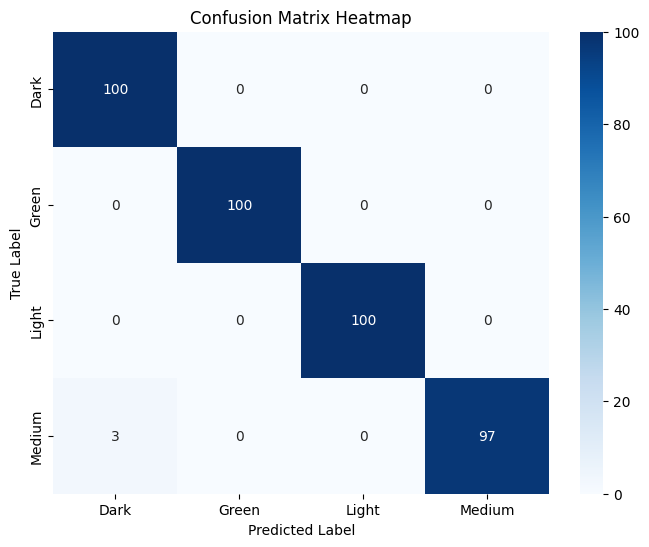

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_mc_set.classes, yticklabels=test_mc_set.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()